In [20]:
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = 'all'

# Data Science and Visualization Imports
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pyproj import Proj

# Values and Imports

In [21]:
alpha_values = [1, 10, 20, 40, 80]

In [22]:
def import_runs(n_runs, area):
    runs = []
    for i in range(n_runs):
        path = 'model_runs/0.00025/_wc_'+area+'_'+str(i)+'.nc'
        run = xr.open_dataset(path)
        runs.append(run)
    return runs

In [23]:
n_runs = 5

bay_runs = import_runs(n_runs, 'bay')
creek_runs = import_runs(n_runs, 'creek')
interior_runs = import_runs(n_runs, 'interior')
baseline_runs = xr.open_dataset('model_runs/0.00025/baseline_wc_full.nc')

## Investigating instabilities

## Water Column Velocities per site

In [24]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='black', lw=4),]

### Average Water Column

In [25]:
bay_runs[0]

<xarray.Dataset>
Dimensions:     (index: 80, Model Runs: 12)
Coordinates:
  * index       (index) int32 0 1 2 3 4 5 6 7 8 9 ... 71 72 73 74 75 76 77 78 79
Dimensions without coordinates: Model Runs
Data variables:
    U Velocity  (Model Runs, index) float64 ...
    Q           (Model Runs, index) float64 ...
    Q2          (Model Runs, index) float64 ...
    Q2L         (Model Runs, index) float64 ...
    Z           (Model Runs, index) float64 ...
    Kq          (Model Runs, index) float64 ...
    nu_t        (Model Runs, index) float64 ...
Attributes:
    description:  Model run results for Bay site.

### All Water Columns

In [26]:
def column_graphs(runtype, n_runs, region_name):
    fig, axs = plt.subplots(n_runs, 1, figsize=(8,25))
    axes = axs.ravel()
    no_model_runs = runtype[0]['Model Runs'].size

    for run in range(n_runs):
        avg_column = runtype[run][['U Velocity', 'Z']].mean(dim='Model Runs').to_dataframe()
        all_runs = runtype[run][['U Velocity', 'Z']].to_dataframe().reset_index().set_index('Model Runs')
        # Fixing Z to bottom for column (switching to water column height from water depth)
        avg_column['Z'] = avg_column['Z'] - avg_column['Z'].min()
        # Plotting Average Column
        avg_column.plot(x='U Velocity', y='Z', color='blue', ax=axes[run])
        for i in range(no_model_runs):
            # Fixing Z to bottom (switching to water column height from water depth)
            new_Z = all_runs.loc[i]['Z'] - all_runs.loc[i]['Z'].min() 
            all_runs.loc[i, 'Z'] = new_Z
            # Plotting
            sample = all_runs.loc[i]
            sample.plot(x='U Velocity', y='Z', color='black', alpha=0.1, ax = axes[run])
        axes[run].legend(custom_lines, ['Average Profile', 'Other Profiles'])
        axes[run].set_title(r'$\alpha=$'+str(alpha_values[run]))
        axes[run].set_ylabel('Water Column Height [m]')
        axes[run].set_xlabel('U velocity [m/s]')
        axes[run].set_xlim(left=0)
        axes[run].set_ylim(bottom=0)
        #plt.ylim(bottom=0)
        axes[run].grid()
    fig.suptitle('Water Column Velocities in '+region_name)
    plt.show()

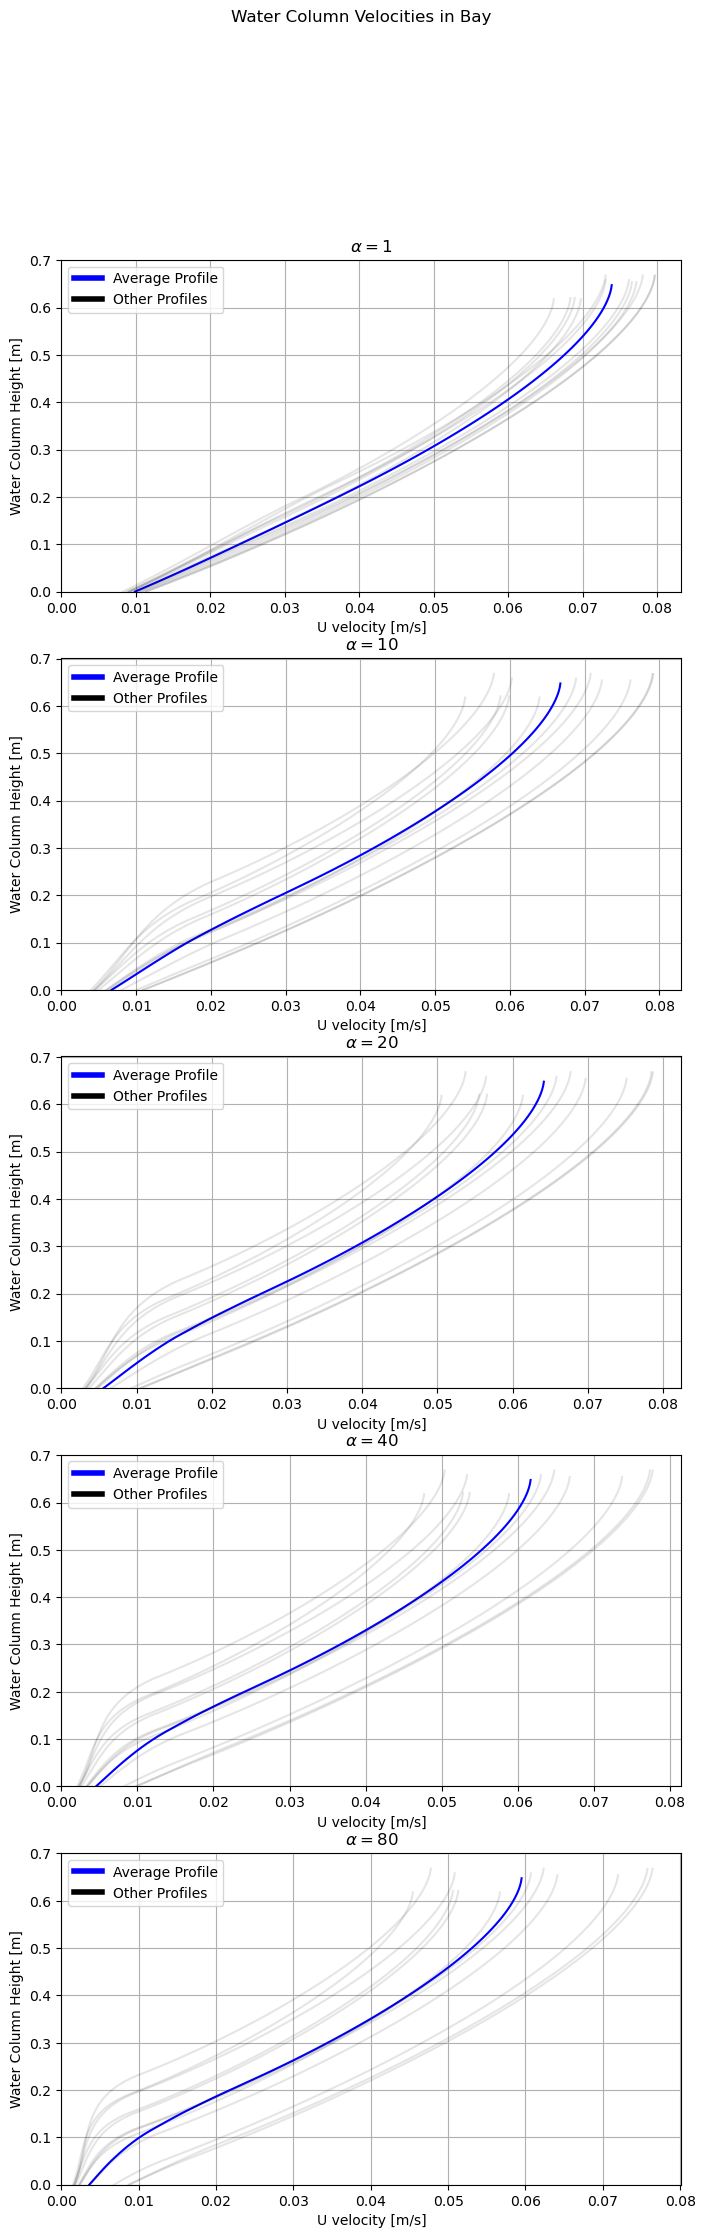

In [27]:
column_graphs(bay_runs, n_runs, 'Bay')

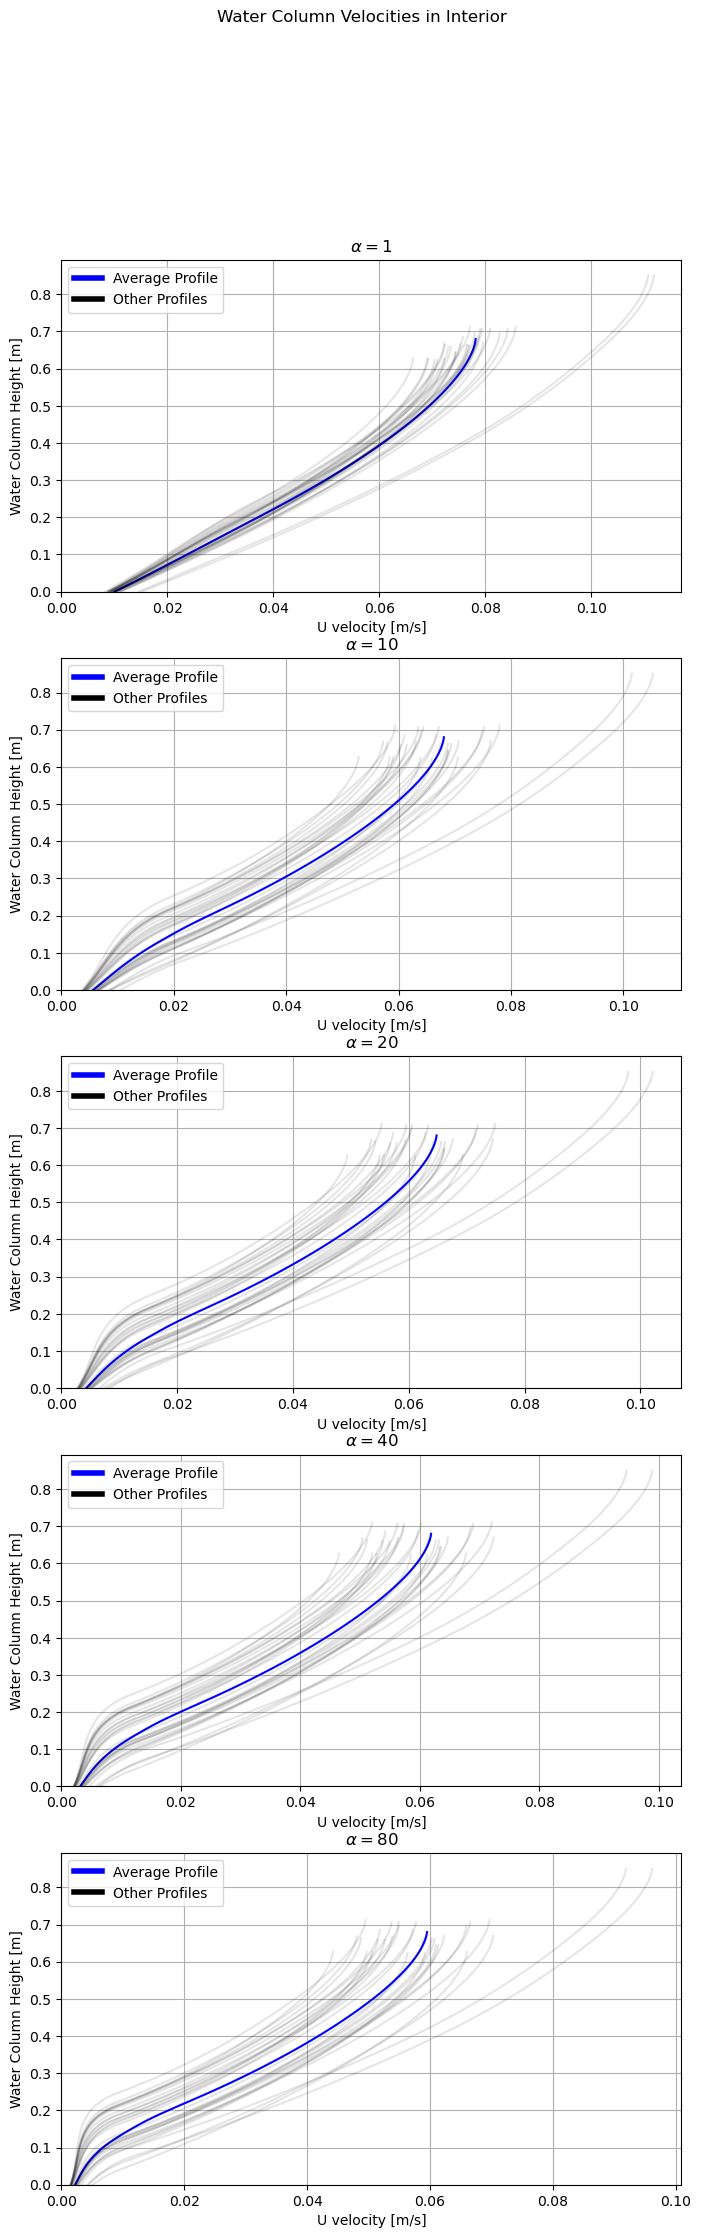

In [28]:
column_graphs(interior_runs, n_runs, 'Interior')

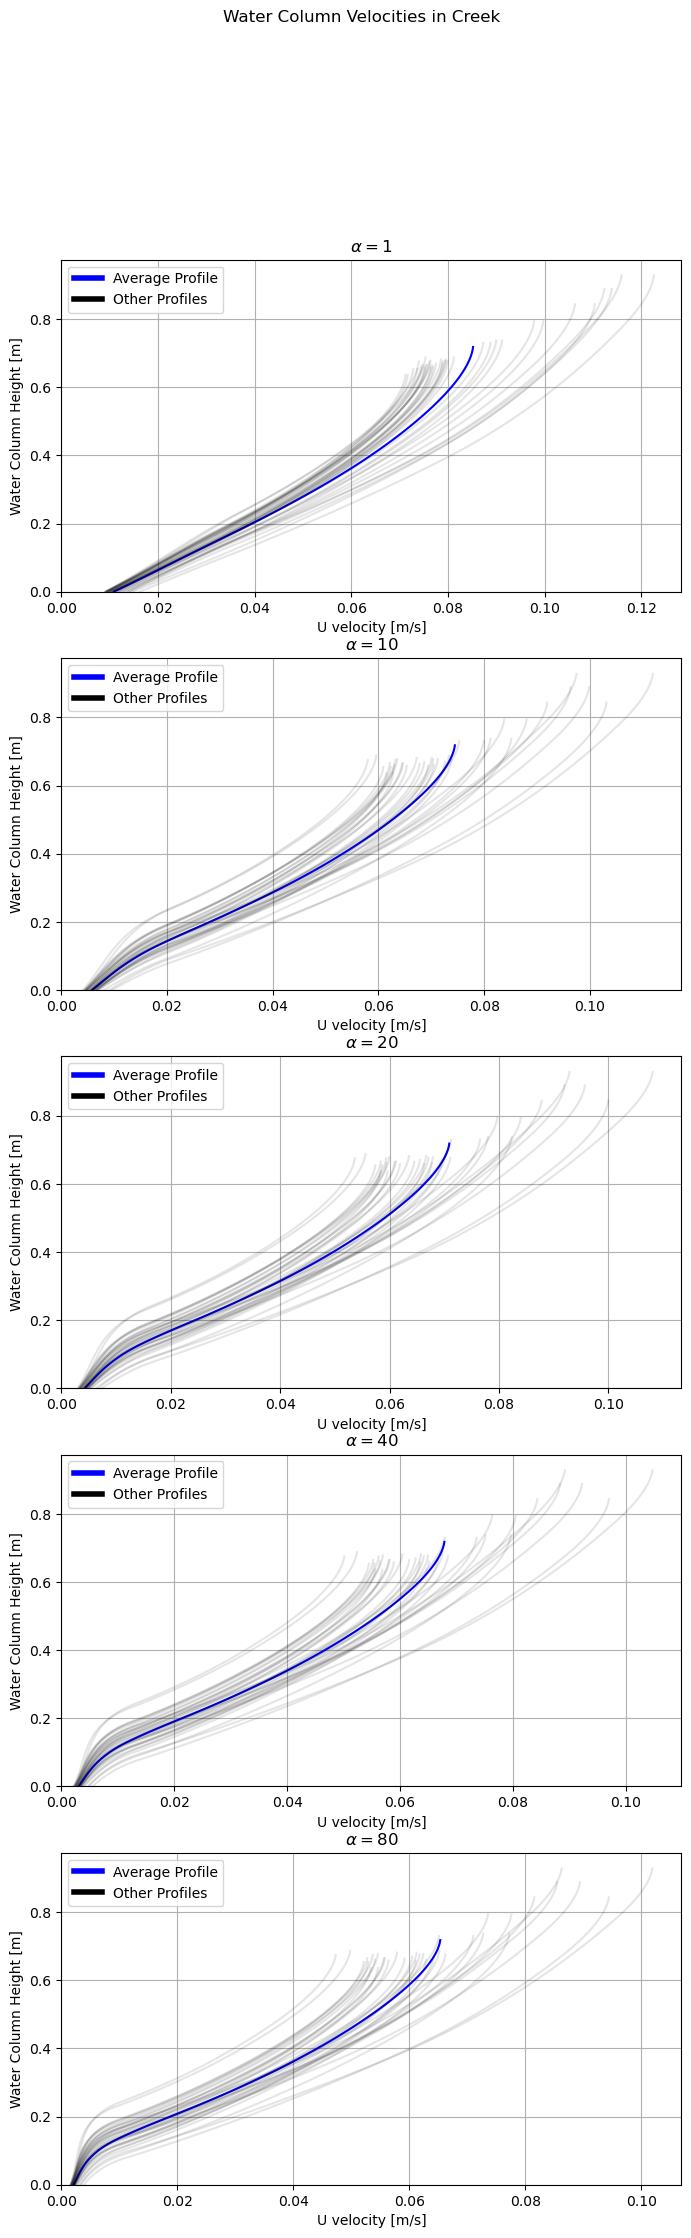

In [29]:
column_graphs(creek_runs, n_runs, 'Creek')

## Violin Plots of Water Columns

## Final Plots

In [30]:
def avg_column_graphs(runtype, n_runs, region_name, axis):
    no_model_runs = runtype[0]['Model Runs'].size
    # Plotting baseline case
    avg_baseline_column = baseline_runs[['U Velocity', 'Z']].mean(dim='Model Runs').to_dataframe()
    avg_baseline_column['Z'] = avg_baseline_column['Z'] - avg_baseline_column['Z'].min()
    avg_baseline_column.plot(x='U Velocity', y='Z', linestyle='dashed', color='k', label='Baseline Unvegetated', ax=axis)
    
    # Plotting all alpha cases
    for run in range(n_runs):
        avg_column = runtype[run][['U Velocity', 'Z']].mean(dim='Model Runs').to_dataframe()
        # Fixing Z to bottom for column (switching to water column height from water depth)
        avg_column['Z'] = avg_column['Z'] - avg_column['Z'].min()
        # Plotting Average Column
        avg_column.plot(x='U Velocity', y='Z', label=r'$\alpha=$'+str(alpha_values[run]), ax=axis)
        axis.set_xlim(left=0)
        axis.set_ylim(bottom=0)
        axis.set_ylabel('Column Height [m]')
        axis.legend(loc='lower right')
        axis.grid()

In [31]:
def combined_graphs(runsite, n_runs, sitename, axis):
    avg_column_graphs(runsite, n_runs, sitename, axis)
    ins = ax.inset_axes([0.075,0.525,0.4,0.3])
    forviolin = pd.DataFrame({
                          'Run 0': runsite[0]['U Velocity'].values.ravel(),
                          'Run 1': runsite[1]['U Velocity'].values.ravel(),
                          'Run 2': runsite[2]['U Velocity'].values.ravel(),
                          'Run 3': runsite[3]['U Velocity'].values.ravel(),
                          'Run 4': runsite[3]['U Velocity'].values.ravel()
                          })
    sns.violinplot(data=forviolin, ax=ins).set(title='U Density Distribution')
    ins.set_axisbelow(True)
    ins.grid(axis='y')
    ins.set_xticklabels(alpha_values)
    ins.set_xlabel(r'$\alpha$')

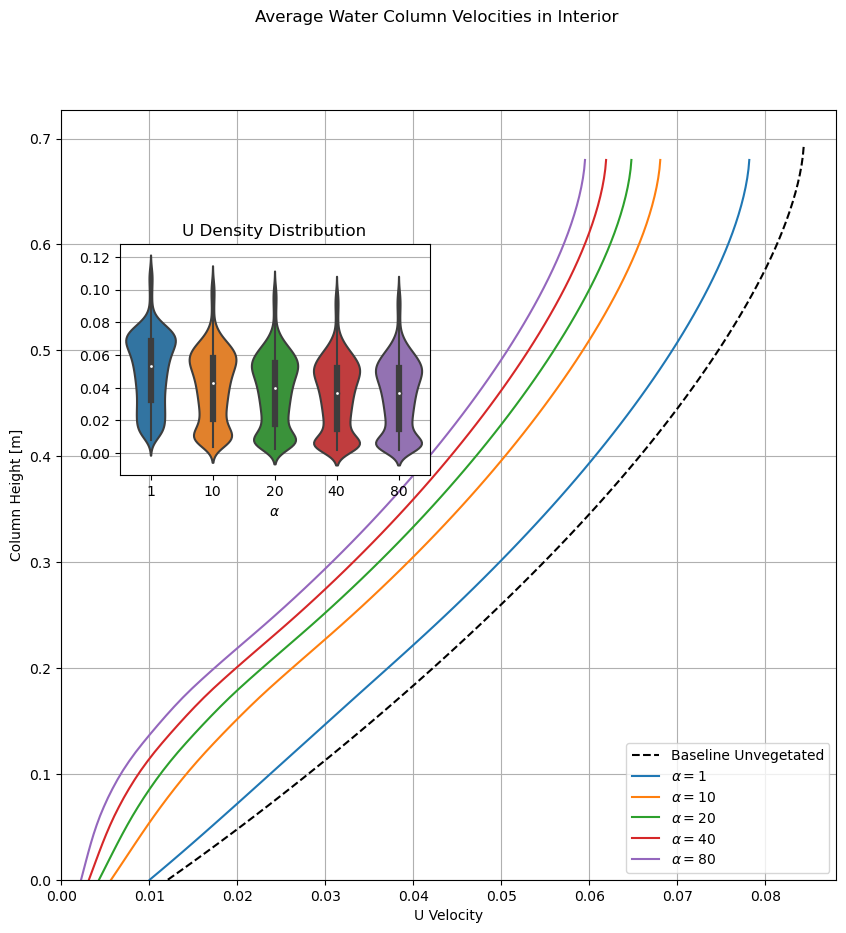

In [32]:
fig, ax = plt.subplots(figsize=(10,10))
sitename = 'Interior'
combined_graphs(interior_runs, n_runs, sitename, ax)
fig.suptitle('Average Water Column Velocities in ' + sitename)
plt.show()

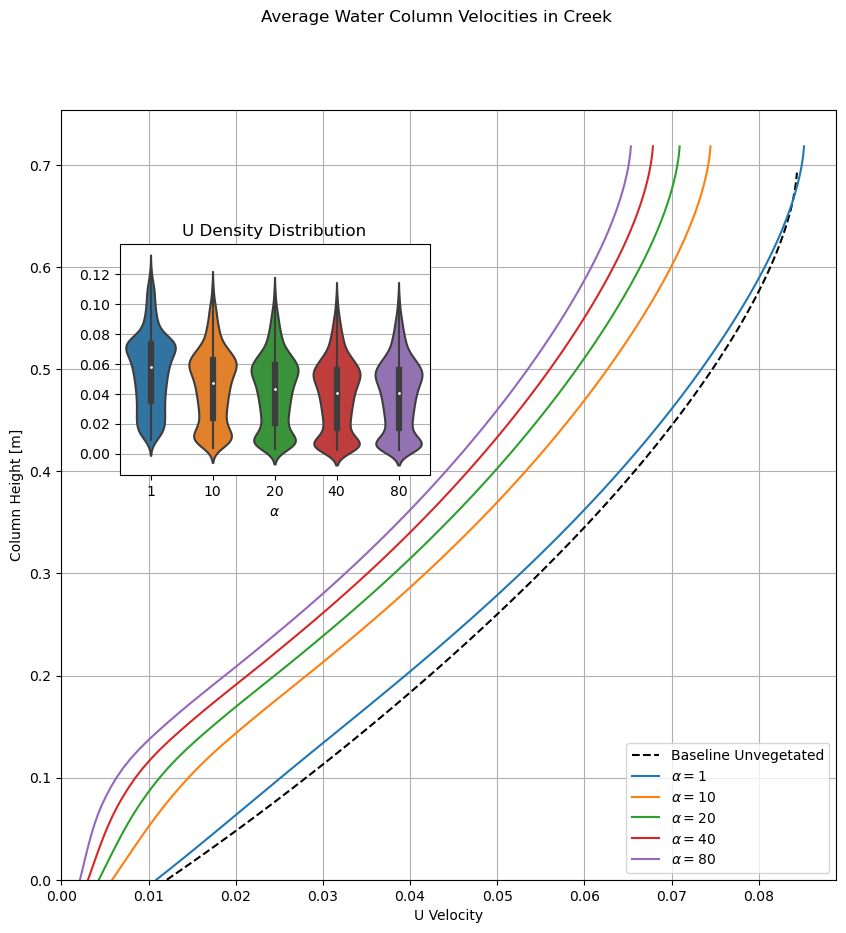

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
sitename = 'Creek'
combined_graphs(creek_runs, n_runs, sitename, ax)
fig.suptitle('Average Water Column Velocities in ' + sitename)
plt.show()

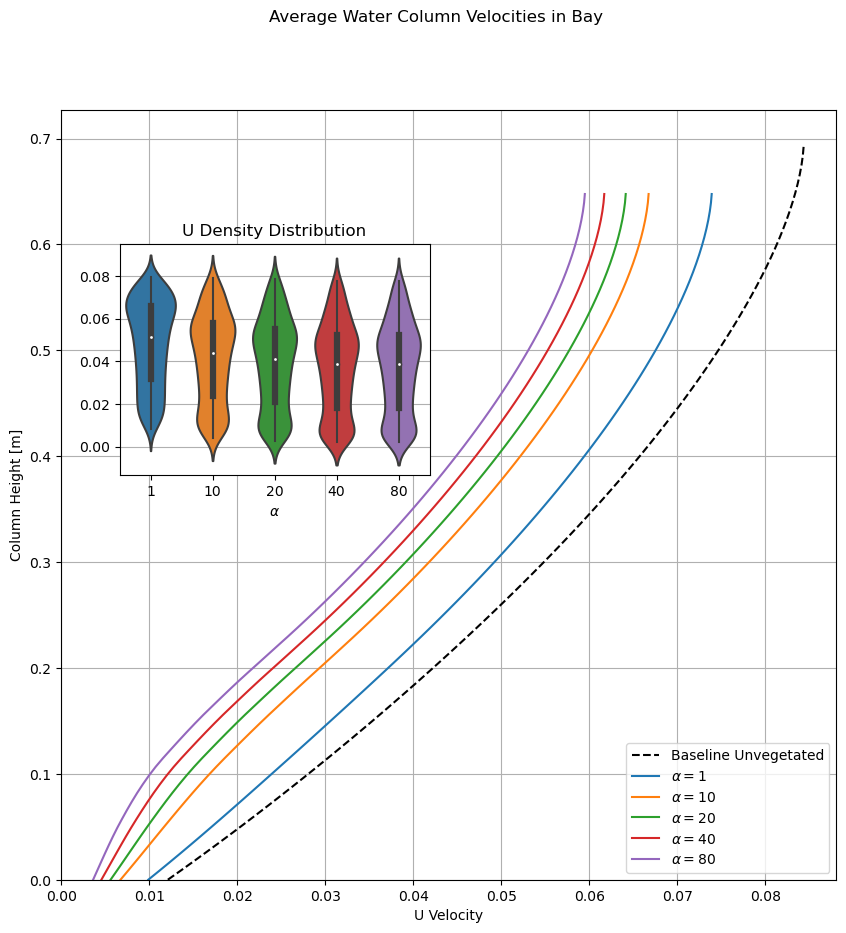

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
sitename = 'Bay'
combined_graphs(bay_runs, n_runs, sitename, ax)
fig.suptitle('Average Water Column Velocities in ' + sitename)
plt.show()

## Statistics

In [35]:
def calc_stats(runtype):
    velocities = pd.DataFrame({'Run 0': runtype[0]['U Velocity'].mean(dim='Model Runs'),
                'Run 1': runtype[1]['U Velocity'].mean(dim='Model Runs'),
                'Run 2': runtype[2]['U Velocity'].mean(dim='Model Runs'),
                'Run 3': runtype[3]['U Velocity'].mean(dim='Model Runs'),
                'Run 4': runtype[4]['U Velocity'].mean(dim='Model Runs')})
    bottom = velocities.iloc[0].values
    top = velocities.iloc[-1].values
    mean = velocities.mean().values
    std = velocities.std()
    data = {'Bottom U': bottom,
            'Top U': top,
            'Mean U': mean,
            'Standard Dev': std}
    stats = pd.DataFrame(data)
    
    return stats

In [36]:
bay_stats = calc_stats(bay_runs)
bay_stats

,Bottom U,Top U,Mean U,Standard Dev
Run 0,0.009876,0.073918,0.048487,0.019781
Run 1,0.006718,0.066746,0.041453,0.019315
Run 2,0.005592,0.064146,0.038941,0.019127
Run 3,0.004545,0.061707,0.036600,0.018942
Run 4,0.003605,0.059498,0.034489,0.018765


In [37]:
interior_stats = calc_stats(interior_runs)
interior_stats

,Bottom U,Top U,Mean U,Standard Dev
Run 0,0.010038,0.078184,0.050825,0.021186
Run 1,0.005647,0.068067,0.040995,0.020480
Run 2,0.004276,0.064785,0.037860,0.020219
Run 3,0.003129,0.061908,0.035134,0.019967
Run 4,0.002237,0.059512,0.032886,0.019733


In [38]:
creek_stats = calc_stats(creek_runs)
creek_stats

,Bottom U,Top U,Mean U,Standard Dev
Run 0,0.010893,0.085185,0.055577,0.023034
Run 1,0.005832,0.074454,0.045090,0.022445
Run 2,0.004296,0.070920,0.041691,0.022201
Run 3,0.003056,0.067852,0.038767,0.021959
Run 4,0.002129,0.065326,0.036385,0.021728
